# AS - TME9
2018--2019

---

Binome : Juliette Ortholand, Stieban Fernandez

## Librairies utiles

In [1]:
import torch
import torch.nn as nn
from unidecode import unidecode

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

from pathlib import Path
# Parcourir les fichiers du répértoire avec glob('*.txt')

import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import tqdm

## Préparation des données

In [20]:
#-------------------------------------------------------
# Extraction des noms et labels
#-------------------------------------------------------
gen = Path("data/names").glob("*.txt")

L = [] # [(nom, pays), ...]
D = {} # {label(int): pays, ...}
for label, file in enumerate(gen):
    D[label] = file.stem
    
    with open(str(file), "r", encoding="utf-8") as f:
        names = f.read().split("\n")[:-1]
    for name in names:
        # Nettoyage
        name = "".join([c for c in unidecode(name.lower()) if c.isalpha()])
        L.append((name, label))

#-------------------------------------------------------
# Encodage
#-------------------------------------------------------
N = 27 # nombre de caractères différents pour le one hot

code_char = lambda x: ord(x)-96

decode_char = lambda x: chr(x+96)

def encode_name(name, N, M=None):
    # N : taille d'un vecteur one hot
    # M : padding
    res = torch.zeros((M if M!=None and M>len(name) else len(name)))
    #res = torch.zeros((M if M!=None and M>len(name) else len(name)), N)
    for i, c in enumerate(name):
        res[i] = code_char(c)
        #res[i, code_char(c)] = 1
    #res[len(name):, 0] = 1
    return res

def decode_name(indxs):
    return "".join([decode_char(indx) for indx in indxs if indx!=0])
    #return "".join([decode_char(indx.argmax()) for indx in indxs if indx[0]!=1])

#-------------------------------------------------------
# Construction du DataSet 
#-------------------------------------------------------
class NameDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        name, label = self.data[index]
        return encode_name(name, N), int(label)
    
    def __len__(self):
        return len(self.data)
    
#-------------------------------------------------------
# DataLoader
#-------------------------------------------------------

def collate_fn(sequences):
    length = max([len(x[0]) for x in sequences])
    data = torch.zeros(len(sequences), length)
    #data = torch.zeros(len(sequences), length, N)
    target = torch.zeros(len(sequences))
    for i, (name, label) in enumerate(sequences):
        data[i, :len(name)] = name
        #data[i, len(name):, 0] = 1 # padding pour s'adapter aux dimensions du batch
        data[i, len(name):] = 0
        target[i] = label
    return data, target
        
    
def get_data_loader(dataset, batch_size):
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, \
                         collate_fn=collate_fn)

#-------------------------------------------------------
# Split Train Val
#-------------------------------------------------------

X, y = np.array(L).T
Xtrain, Xval, ytrain, yval = train_test_split(X, y)

train_set = NameDataset(np.vstack((Xtrain, ytrain)).T)
val_set = NameDataset(np.vstack((Xval, yval)).T)

train_iter = get_data_loader(train_set, 32)
val_iter = get_data_loader(val_set, 32)

$ \rightarrow $ Obtenir un Dataset ne contenant que des noms d'un pays

In [21]:
def get_dataloaders_country(country, batch_size=32):
    L_country = [x for x in L if x[1] == country]

    X, y = np.array(L_country).T
    Xtrain, Xval, ytrain, yval = train_test_split(X, y)

    train_set = NameDataset(np.vstack((Xtrain, ytrain)).T)
    val_set = NameDataset(np.vstack((Xval, yval)).T)

    train_iter = get_data_loader(train_set, batch_size)
    val_iter = get_data_loader(val_set, batch_size)
    
    return train_iter, val_iter

Test

In [22]:
decode_name(encode_name("pierre", N, 19))

'pierre'

In [23]:
for x, y in train_iter:
    ex, lab = x, y
    print(x.shape, y.shape)
    break

torch.Size([32, 10]) torch.Size([32])


---

## Long-Short Term Memory

### Modèle

In [18]:
class LSTM(nn.Module):
    
    def __init__(self,input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        
        #Couches
        self.emb = nn.Embedding(27, input_size)
        
        self.linF = [nn.Linear(input_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linI = [nn.Linear(input_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linC = [nn.Linear(input_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linO = [nn.Linear(input_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linOp = nn.Linear(hidden_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.clas = nn.Linear(hidden_size, output_size)
    
    def forward(self, X):
        emb_X = self.emb(X)
        c, h = self.initHidden()
        
        for _input in emb_X:            
            #Bloc 1
            tmp2 = self.sigmoid(self.linF[1](h)+self.linF[0](_input))
            
            #Bloc 2
            tmp3 = self.sigmoid(self.linI[1](h)+self.linI[0](_input)) \
                    * self.tanh(self.linC[1](h)+self.linC[0](_input))
            
            #Application
            c = (c * tmp2)+ tmp3
            
            #Bloc 3 
            h = self.sigmoid(self.linO[1](h)+self.linO[0](_input)) * self.tanh(self.linOp(c))
        
        out = self.clas(h)                                     
                                                          
        return out
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size),torch.zeros(1, self.hidden_size)
    
input_size, hidden_size, output_size = 50, 110, len(D)

In [24]:
model = LSTM(input_size, hidden_size, output_size)
out = model(ex.transpose(0,1).long())

for i, e in enumerate(out):
    print(decode_name(ex[i]), ":", D[e.argmax().item()])

ruda : Polish
kinsey : Polish
yudahin : Polish
bakotin : Polish
tselischev : Vietnamese
nakamoto : Polish
nisbet : Polish
shan : Polish
abrahimoff : Polish
bakiroff : Polish
barsetti : Polish
sula : Polish
espina : Polish
haratyan : German
issa : Polish
gluhih : Polish
rapp : Polish
maryltsev : Polish
charnetsky : Chinese
han : Polish
abovyan : Polish
daugelo : Polish
gatti : Polish
daher : Polish
schlimme : Polish
tumko : Polish
reijnders : Polish
gefter : Polish
naifeh : Polish
dahaev : Polish
averchenko : German
babakin : Polish


### Classification

In [25]:
model = LSTM(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

def accuracy(ypred, y):
    ### Calcul du score
    return (ypred.argmax(dim=1) == y).float().mean()

def fit_eval_rnn(model, loss, optim, train_iter, val_iter, n_epochs):
    train_loss = []
    train_score = []
    val_loss = []
    val_score = []

    ### APPRENTISSAGE
    #--------------------------------------------------------
    for i in tqdm(range(n_epochs)):
        
        model.train()
        ####### TRAIN #######
        costs_train = []
        scores_train = []
        for x, l in train_iter:

            x = x.transpose(0,1).long()
            l = l.long()

            out = model(x)
            cost = loss(out, l)
            optim.zero_grad()
            cost.backward()
            optim.step()

            costs_train.append(cost)
            scores_train.append(accuracy(out, l))

        train_loss.append(torch.tensor(costs_train).mean())
        train_score.append(torch.tensor(scores_train).mean())

        model.eval()
        ####### VALID #######
        costs_val = []
        scores_val = []
        for x, l in val_iter:
            x = x.transpose(0,1).long()
            l = l.long()

            out = model(x)
            cost = loss(out, l)

            costs_val.append(cost)
            scores_val.append(accuracy(out, l))

        val_loss.append(torch.tensor(costs_val).mean())
        val_score.append(torch.tensor(scores_val).mean())
        
    return train_loss, val_loss, train_score, val_score


def show_loss_score(train_loss, val_loss, train_score, val_score):
    ### AFFICHAGE LOSS ET SCORE
    #--------------------------------------------------------
    plt.figure(figsize=(10,7))
    plt.plot(train_loss, c="red", label="train")
    plt.plot(val_loss, c="b", label="val")
    plt.legend(loc="best")
    plt.show()

    plt.figure(figsize=(10,7))
    plt.plot(train_score, c="red", label="train")
    plt.plot(val_score, c="b", label="val")
    plt.legend(loc="best")
    plt.show()

100%|██████████████████████████████████████████| 20/20 [06:30<00:00, 19.86s/it]


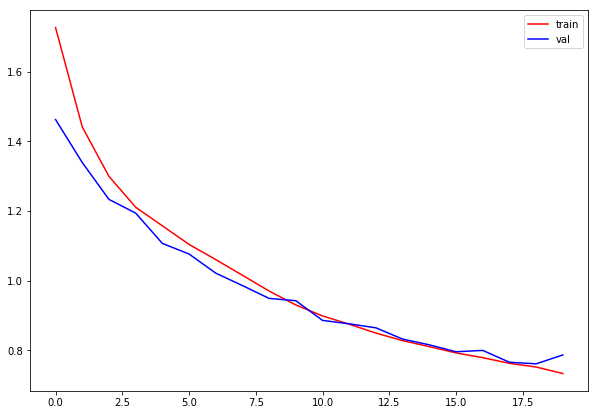

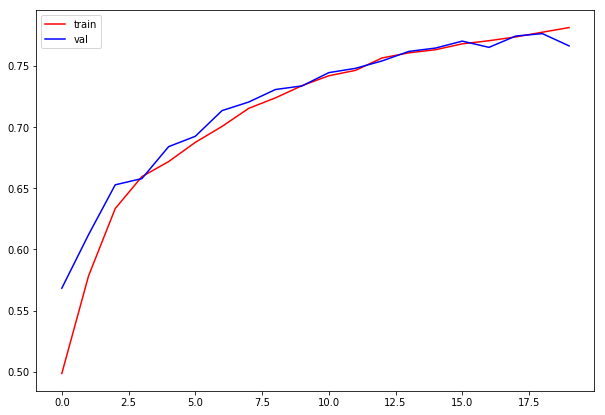

In [26]:
res = fit_eval_rnn(model, loss, optim, train_iter, val_iter, n_epochs)
show_loss_score(*res)

### Tests

In [ ]:
...

---


## Génération

Dans un premier temps, nous considérons hidden_size comme étant la taille de H et C (memoires)

In [41]:
class LSTM2(nn.Module):
    
    def __init__(self,input_size, hidden_size, output_size):
        super(LSTM2, self).__init__()
        
        self.hidden_size = hidden_size
        
        #Couches
        self.emb = nn.Embedding(27, input_size)
        
        self.linF = [nn.Linear(input_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linI = [nn.Linear(input_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linC = [nn.Linear(input_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linO = [nn.Linear(input_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linOp = nn.Linear(hidden_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.clas = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, h, c):
        emb_x = self.emb(x)
        c, h = self.initHidden()
                   
        #Bloc 1
        tmp2 = self.sigmoid(self.linF[1](h)+self.linF[0](emb_x))

        #Bloc 2
        tmp3 = self.sigmoid(self.linI[1](h)+self.linI[0](emb_x)) \
                * self.tanh(self.linC[1](h)+self.linC[0](emb_x))

        #Application
        c = (c * tmp2)+ tmp3

        #Bloc 3 
        h = self.sigmoid(self.linO[1](h)+self.linO[0](emb_x)) * self.tanh(self.linOp(c))

        out = self.clas(h)                                     
                                                          
        return out, h, c
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size),torch.zeros(1, self.hidden_size)
    
input_size, hidden_size, output_size = 50, 110, 27

### Apprentissage

In [56]:
def accuracy(ypred, y):
    ### Calcul du score
    return (ypred.argmax(dim=1) == y).float().mean()


def fit_eval_rnn_gen(model, loss, optim, train_iter, val_iter, n_epochs):
    train_loss = []
    train_score = []
    val_loss = []
    val_score = []

    ### APPRENTISSAGE
    #--------------------------------------------------------
    for i in tqdm(range(n_epochs)):
        
        model.train()
        ####### TRAIN #######
        costs_train = []
        scores_train = []
        for x, l in train_iter:

            x = x.transpose(0,1).long()
            
            hidden, h2 = model.initHidden()
            for i in range(len(x)-1):
                c, next_c = x[i], x[i+1]
                
                out, hidden, h2 = model(c, hidden, h2)
                cost = loss(out, next_c)
                
                optim.zero_grad()
                cost.backward(retain_graph=True)
                optim.step()
                

                costs_train.append(cost)
                scores_train.append(accuracy(out, next_c))

        train_loss.append(torch.tensor(costs_train).mean())
        train_score.append(torch.tensor(scores_train).mean())

        model.eval()
        ####### VALID #######
        costs_val = []
        scores_val = []
        for x, l in val_iter:
            x = x.transpose(0,1).long()
            
            hidden, h2 = model.initHidden()
            for i in range(len(x)-1):
                c, next_c = x[i], x[i+1]
                
                out, hidden, h2 = model(c, hidden, h2)
                cost = loss(out, next_c)

                costs_val.append(cost)
                scores_val.append(accuracy(out, next_c))

        val_loss.append(torch.tensor(costs_val).mean())
        val_score.append(torch.tensor(scores_val).mean())
        
    return train_loss, val_loss, train_score, val_score


def generate_name(model, letter, maxlen=10):
    letter = encode_name(letter, 1).long()
    s = [letter]
    hidden, h2 = model.initHidden()
    
    for i in range(maxlen):
        out, hidden, h2 = model(letter, hidden, h2)
        letter = out.argmax(1)
        s.append(letter)
    return decode_name(s)

Test avec différents pays

In [57]:
alphabet = "abcdefghijklmnopqrstuvwxyz"

1. Noms chinois

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 22.63it/s]


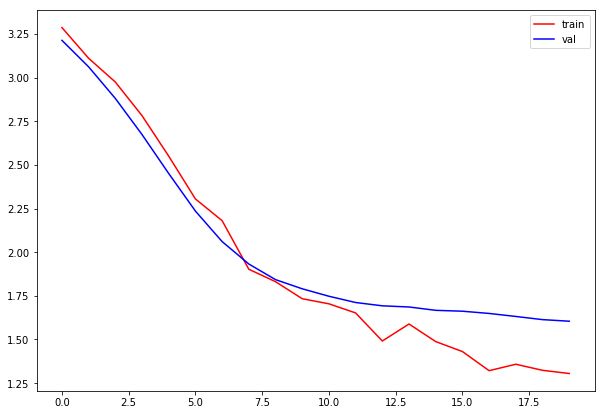

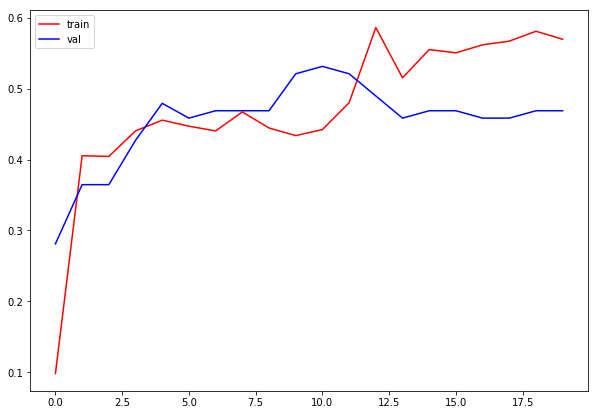

ang
bang
cho
do
eo
f
g
ho
i
jo
k
l
m
ng
o
pang
qho
ryo
so
to
ung
vng
wang
xng
yo
z


In [62]:
model = LSTM2(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

train_iter, val_iter = get_dataloaders_country(11)
res = fit_eval_rnn_gen(model, loss, optim, train_iter, val_iter, n_epochs)
show_loss_score(*res)

for l in alphabet:
    print(generate_name(model, l, 4))

2. Noms français

100%|██████████████████████████████████████████| 20/20 [00:05<00:00,  4.18it/s]


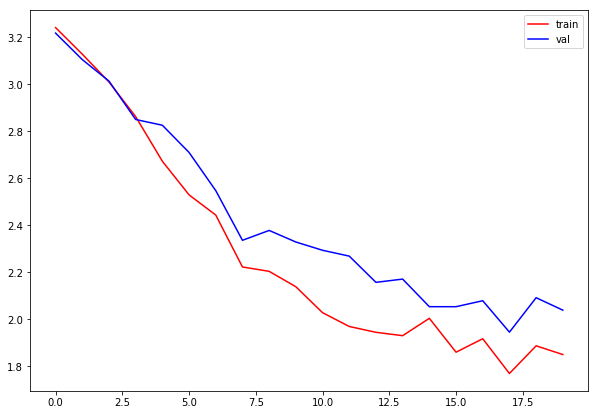

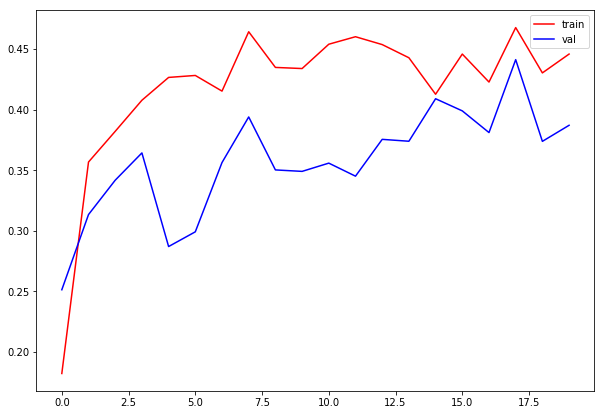

au
b
c
d
e
fe
ge
h
ie
j
k
le
me
n
on
p
qn
r
s
t
u
v
w
x
y
ze


In [64]:
model = LSTM2(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 20

train_iter, val_iter = get_dataloaders_country(5)
res = fit_eval_rnn_gen(model, loss, optim, train_iter, val_iter, n_epochs)
show_loss_score(*res)

for l in alphabet:
    print(generate_name(model, l, 4))

3. Noms russes

100%|██████████████████████████████████████████| 20/20 [03:15<00:00,  9.25s/it]


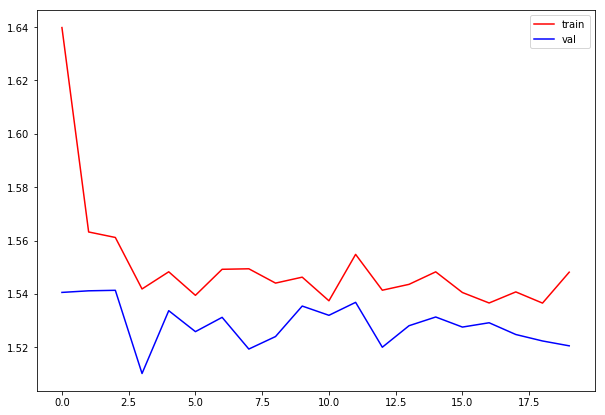

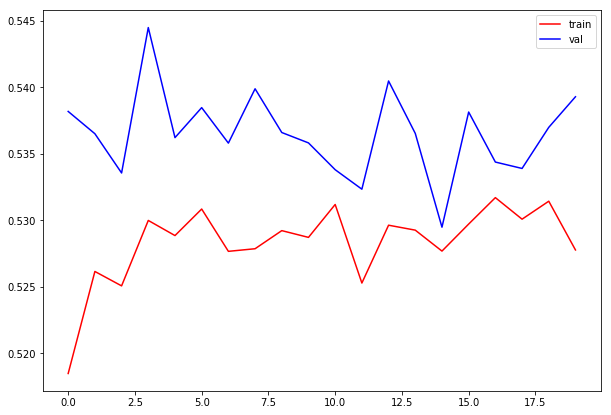

an
ban
chan
dov
ev
fffffffffff
gan
han
in
jan
kov
lev
man
n
ov
pov
qan
rov
skov
tskov
ulev
v
wev
x
y
zhan


In [74]:
model = LSTM2(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

train_iter, val_iter = get_dataloaders_country(14)
res = fit_eval_rnn_gen(model, loss, optim, train_iter, val_iter, n_epochs)
show_loss_score(*res)

for l in alphabet:
    print(generate_name(model, l))

Nous remarquons des performances moins bonnes que pour le RNN

### Modèle avec hidden1_size et hidden2_size

In [75]:
...

Ellipsis

### Autres méthodes pour la construction des batchs

In [27]:
...

Ellipsis